# XGBoost for Prediction using Senator Trading Data
* Laurent Lanteigne
* Max Frankel
* Yan Sun


### Introduction
The United States House and Senate are exempt from insider trading restrictions. Since the passage of the STOCK act in 2012, congresspeoples' trades are made public after a small delay. Out project focuses on the idea that legal insider trading might be a useful source of information for forecasting stock prices. We use an XGBoost algorithm to help determine relationships between insider information and future prices, and thus perhaps gain an advantage in forecasting returns of individal securities.  

#### Legal Insider Trading
Insiders have different kinds of information advantages. First, they know in advance which major events will affect stock prices. This type of advantage disappears after the events are announced, usually within a short time. Second, insiders can better assess the company’s earnings prospects and growth potential than outsiders. This type of information advantage is usually long term and does not rely on specific events. Third, insiders can better assess the intrinsic value of a company than outsiders and can thus identify and exploit opportunities when the stock market overvalues or undervalues the company. Fourth, insiders have a better sense of industry and macro-economy trends and thus tend to predict future macroeconomic directions more accurately. The first three types of advantages can increase insiders’ ability to predict firm-level price movement more precisely. They seem to always be able to cash in when the price is high and purchase when the price is low. The fourth advantage increases aggregate insiders’ ability to time the market (Zhu, Wang, Yang 2014). According to STOCK ACT, US senators are required to disclose their stock trade publicly, and we can obtain the stock trade feed including the file and transaction dates, stock issuers, lower and higher bound for trade size, and transaction side from the Securities and Exchange Commision(SEC) website. 

#### XGBoost
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. When it comes to small-to-medium structured/tabular data, XGBoost estalishes itself among all other machine learning algorithms in both speed and performance. We'll do a quick review of GBM: Gradient Boosting Machine and why XGBoost suits the need for this project.

Boosting algorithm fits the ensemble models of the following structure:

$$
f(x) = \sum_{m=0}^{M} f_m(x) = f_0(x) + \sum_{m=1}^M \theta_m\phi_m(x).
$$

where $f_0$ is the initial guess, $\phi_m(x)$ is the base estimator at the $m^{th}$ iteration, and $\theta_m$ is the weight for the $m^{th}$ estimator. GBM constructs a forward addititive model by implementing gradient descent in the function space. Similar to the classic gradient descent framework in parameter space, at the $m^{th}$ iteration, the direction of the speest descent is given by 

$$
-g_m(x) = - \left(\frac{\partial L(y,f(x))}{\partial f(x)}\right)_{f(x)=f^{m-1}(x)}.
$$
This gives the direction and to reduce the loss function. Typically, a squared error is used as the loss function this leads to 

$$
\phi_m = \text{argmin}_{\phi}\sum_{i=1}^n \left[-g_m(x_i)-\phi(x_i)\right]^2.
$$

As to figure out the size of the step toward the negative gradient, in similar fashion we have

$$
\rho_m = \text{argmin}_\rho \sum_{i=1}^n L\left(y_i f^{m-1}(x_i) + \rho \phi_m(x_i)\right).
$$

Finally

$$
f_m(x) = \eta \rho_m \phi_m(x),
$$
where $\eta$ is the learning rate parameter.

XGBoost, short for "Extreme Gradient Boosting", introduced by Tianqi Chen and Carlos Guestrin in 2016 (1). GBM divides the optimization problem mainly in two different parts by determining first, the direction of the step $\phi_m$ and then the optimal step length $\rho_m$. XGBoost tries to do this in one step by directly solving 

$$
\frac{\partial L(y, f^{m-1}(x)+f_m(x)}{\partial f_m(x)} = 0
$$
for each input in the data set. The main reason to use XGBoost for a GBM Model is that by doing a second-order Taylor expansion of the loss function and optimizing the problem in one step instead of two, the convergence and speed of execution of the algorithm is greatly improved. 

____________________________________________________________________________________________________________________________________________________________________________________________
(1) Tianqi Chen, Carlos Guestrin, 2016 XGBoost: A Scalable Tree Boosting System https://arxiv.org/abs/1603.02754



### Model

#### Data Sourcing

The first step of the project was to collect information about transactions from member of the Senate. Some data providers sold the information but it was limited, incomplete and limited up to 2016.

Therefore, we explored where we could find the data and scrape it ourselves. Using 'https://efdsearch.senate.gov', the structure of the website made it possible to go over the reports that are published everytime a Senator enters into a transaction with the market and extract the transactional data from it. 

The script has been attached to the project documentation and can be found under the name 'web_scraping.py'. The script takes several hours to finish due to the limited rate of web pages being scraped in order to make sure that the server doesn't deny access to the client while the code is running.

#### Data Cleaning and Variable Selection

The caveat of using an htlm web scraper via the library BeautifulSoup, is that the raw dataset requires a lot of cleaning. Some of the tickers were named after the company instead of the NYSE ticker such as 'AMAZON':"AMZN", 'APPLE':"AAPL". 

A lot of added characters, white spaces, and common mistakes human typed reports usually includes had to be fixed. 

The end result was that from the reports, we were able to extract the following features:

* file_date : Date that the report was published.
* tx_date: Transaction Date. 
* full_name: The Senator's full name. 
* order_type: Whether it was a (1) Purchase, (2) Sale (Partial), (3) Sale (Full) 
* ticker: The stock tradable ticker.
* lower_bound/higher_boud: The report doesn't stipulate an exact trade nominal but a range of possible values that the nominal falls into. 


From Quandl, we also collated some data which pertained to the ticker referenced in each trade. Of these variables imported, we chose to focus primarily on the industry code and the market beta.

We want to focus on the insider information that Senators may have. In this vein, we pick the the variables that might be most related to insider activity. Here are the motivations behind the variable selections:

* senator full name -- does a certain Senator have a higher win rate than others?
* sectoral code -- is a Senator on a committee which oversees a certain industry?
* ticker -- does a Senator have a particularly good relationship with a certain company?
* lower bound/higher bound -- is a Senator trading out of proportion to their usual size?
* market beta -- is the ticker an easy vehicle for macroeconomic insider trading? 
* order type -- does a Senator have a positive or negative view?

Ultimately, we were limited by the size of the dataset to a relatively small (for a ML model) number of predictors.



#### Model Optimization

#### Model Performance
See Section 4.1.1

### Trading Strategy Implementation

#### Key Assumptions
The initial capital is 1,000,000,000.  

#### Entry and Exit Rules

##### Entry Signal
On each filing date, the strategy enters a long/short position if there is a win signal for the Senator's transaction from the output generated by the XGBoost model.

###### Leverage
When the leverage parameter is set to 0, the strategy takes an initial position size of 10,000 for each long position. Depending on the short bias parameter, the strategy takes some multiplier of that 10,000 on each short. Since the initial capital is 1,000,000 times this, this setting lets you look at the strategy PnL in some sense from an ergodic perspective as opposed to a time-average one. 

If the leverage parameter is set to -1, the strategy weights the initial position size by the midpoint of the reported range in the relevant trade disclosure.

If the leveral paramter is greater than 0, the long position entry size is set as a percentage of the NLQ (net liquidating value) of the portfolio's holding + cash, scaling up and down depending on current profitability. 

For all the leverage parameters, each short taken is the default long position size multiplied by the short bias. 

##### Funding
If the current cash holdings go negative, the backtest allows you to vary the cost of acessing funding to better assess the vulnerability of the strategy to changes in funding rates. The implementation assumes interest on cash reserves at 150bps less than the funding rate, down to a floor of 0%. 

##### Exit Signal
On each trading day, the strategy would check two exit signals for outstanding positions.

###### Stop Loss
If the simulation experiences a day such that the present position value has lost more than a proportion $s$ of the current cash holdings and outstanding position value at position entry time), then force an exit at current prices. 

###### Force Exit after a Predetermined Time Period
The strategy does not to hold any position longer than a predetermined period $\tau$ due to funding and liquidity issues as well as to isolate the "alpha" in the signal. If any open positions have been held for $\tau$ days, the corresponding positions are closed.

#### Transaction Costs
The strategy assume we trade on the close, with some type of MOC order. In order to get a rough approximation of the impact of transaction costs on strategy performance, we take a default assumption for the backtest analytics that market impact of each trade is 50bps per trade. However, the parameter allows you vary the market impact and look at the performance of the trading strategy if you assume a larger amount of capital allocated. 

#### Short Bias
Since most of the trades during the OOS period were long trades, in order to decorrelate the strategy from the broader market uplift and isolate any potential alpha from the signal, we can adjust the strategy to overweight short trades. Short bias is a parameter which simply sets the relative ratio of short position sizing to long position sizing.

#### Miscellaneous

### Performance, Strategy Exploration, and Analytics

#### Looking at different predictor specifications:

We trained the XGBoost model on two different specifications:  
The first model specification used the following predictors:
-  senator full name, ticker, market beta, order type, and trade size (combination of upper bound and lower bound)

The second model specification used the same predictors but swapped out trade size for the sectoral code:
 -  senator full name, ticker, market beta, order type, and sectoral code
 
We found that we got better performance by looking at the first specification -- what follows is a brief overview of the differences in model out of sample performance as well as a rationale for the choice of excluding sectoral data.


##### XGBoost Output Interpretation

In [1]:
import xgb_model as xg
xg.print_evaluation()

First Specification Performance:
Optimized w: 1.0002
Dataset win/loss ratio: 50.4343%
out-of-sample accuracy: 60.4046%
out-of-sample win accuracy: 63.9269%
out-of-sample false positive accuracy: 36.0731%


In [2]:
xg.print_evaluation(sector = True)

Second Specification Performance:
Optimized w: 1.0344
Dataset win/loss ratio: 48.8889%
out-of-sample accuracy: 54.1667%
out-of-sample win accuracy: 53.0120%
out-of-sample false positive accuracy: 46.9880%


In the first model, the dataset is actually quite well balanced in terms of win/loss ratio. Since our target is a binary classifier of whether to open a trade or not, we do not need to allocate more weight to one set of classification. We can observe this by looking at the optimized weight on classifying winnable trade, which is very close to 1. What we are doing here is splitting our data set according to the following structure. 

* 80% of the dataset is considering Training Data and 20% of it is Testing Data
* In the 80% Training data, we shuffle the data and 75% of it remains Training and 25% of it becomes the Validation Set. We make sure to have the same representation of the classifier (i.e. same ratio of winning in losing trades). 
* We use the validation set to optimize the parameter that allocates more or less weight into classification of winnable trade. 


Under this structure, the optimization scheme target is to maximize winning trade accuracy (i.e. true positives). The reason we chose to maximize the true positives versus the model accuracy is that we use the model to signal whether or not we should engage in a trade. Say we had a dataset where only 10% of the trades were winning, a model would quickly learn to not trade to achieve the highest accuracy but that would be a very useless model for practical purposes. For the first model, we can see that the model out-of-sample accuracy is ~60% but the out-of-sample winning accuracy is ~64% (true positives). While ~36% of the trades we label as winning trades turned out to not be winning trades (false positives).

As for the second model, the classifyer is not as balanced so we can observe that the optimization scheme puts a little bit more weight into classifying winnable trades. In this model we added the sectoral code of the ticker hoping that the added information would translate to a better scoring of the model, Unfortunately, when trying to grab the sectoral code for many tickers the information was unavailable so in order to have a dataset with sectoral codes we ended up losing many transactions to run the analysis. The reduced number of transactiosn to train the model ends up reducing the performance more than what the sectoral code can compensate. In this one, the out-of-sample accuracy is actually better than the true positives.

##### Strategy Performance for some Sample Paths

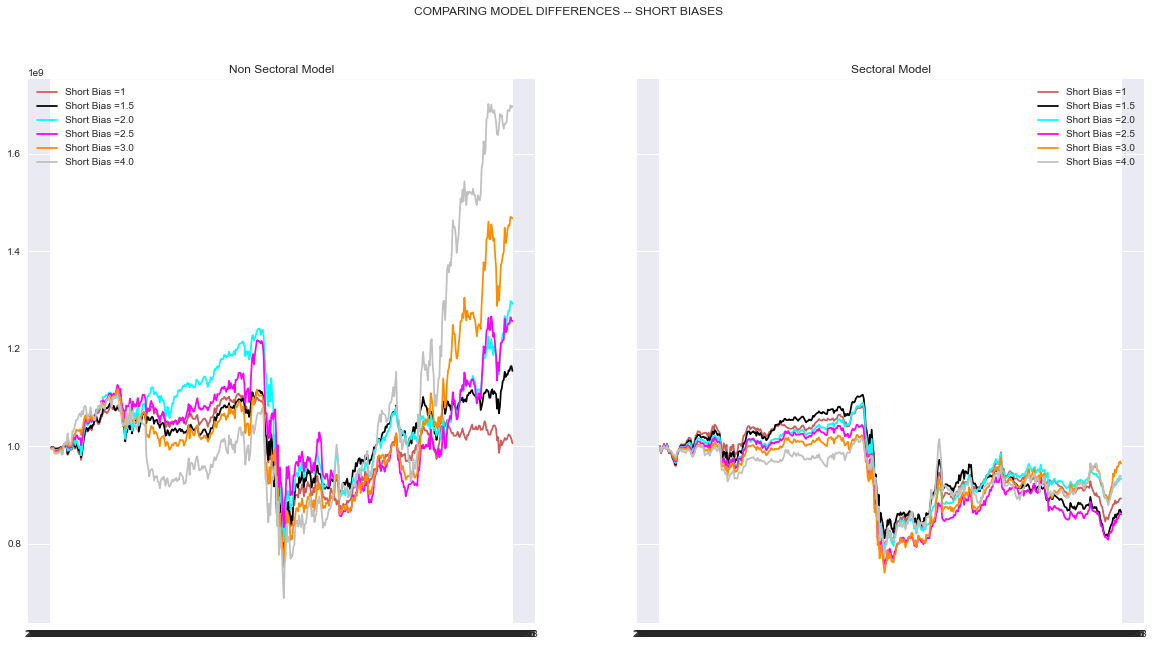

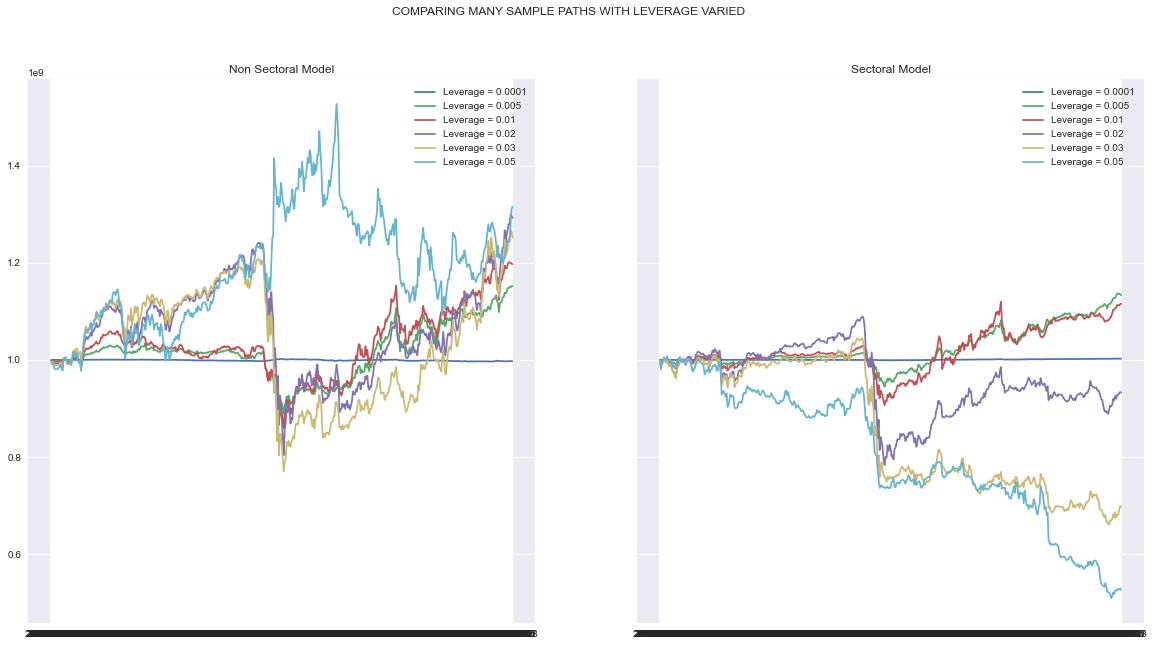

In [1]:
import Ana as d
d.plot_shortbias_differences((20,10))
d.plot_leverage_differences((20,10))

You cas see consistent outperformance for the model which doesn't include the parameters

### Taking a look at a sample PnL path with reasonable apriori parameters

In order to avoid overfitting the model in this second stage of parameter fitting (initally we fit the XGBoost model, now we are fitting the trading strategy parameters) it is a good idea to come up with some reasonable apriori parameters and take a look the model performance, before optimizing the Trading Strategy parameters.

For this 'first-look' check of whether the strategy realizes some edge from the dataset we chose the following parameter values with justifications:

* short bias = 2.5 -- since we are trying to isolate the edge from the dataset, we want to reduce the correlation between the strategies PnL and the overall market. Senators traded long/short in the sample period at roughly this ratio.


* leverage = 0.001 -- we want to look at any edge coming from the strategy in terms of the expected value of the trade, and not worry about the non-ergodic effects of trading over time.


* stop_loss_ratio = 0.0007 -- if the position has lost more than 30% of its value, kill the trade. There is no specific justification but this seems reasonable.


* market_impact  = 50bps -- we want to look at the edge first and worry about the capacity later, so we have a relatively small trading cost. 


* force_exit_days = 100 -- this corresponds roughly to the 90 day return that our XGBoost model trained on.


* funding_rate = 150bps -- this corresponds roughly to the historical average over the backtest period. In any case, the starting capital is many orders of magnitude larger than the trade size, so it doesn't have a big impact for this early look at strategy performance. 




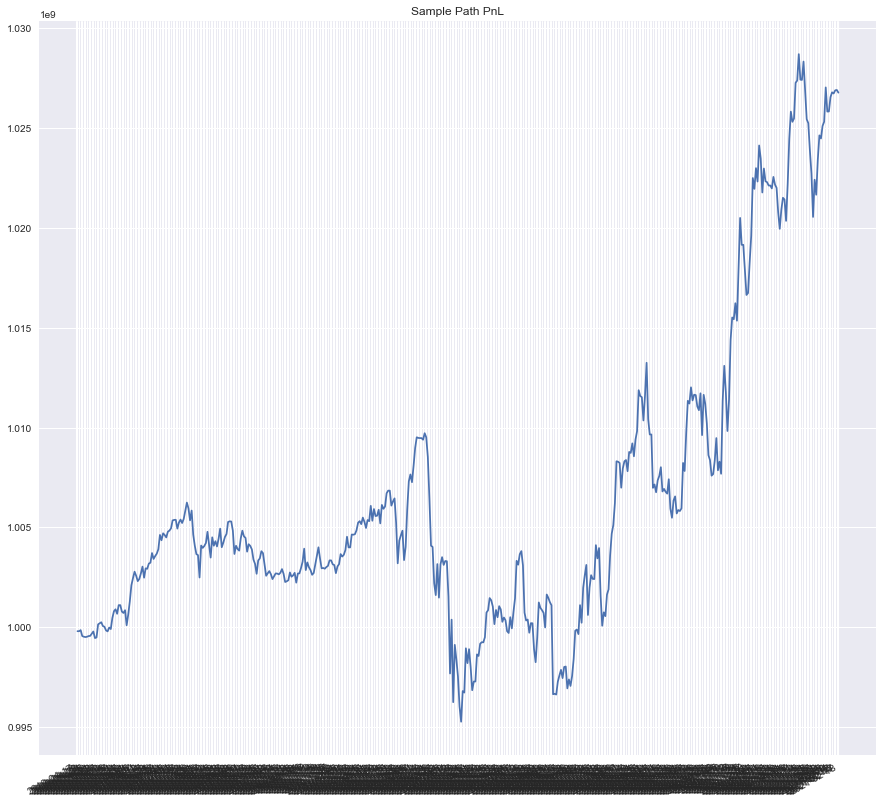

In [17]:
import Ana as d
d.plot_sample_pnl_path((15,15),'sample_path.pkl')

You can see that the strategy is still fairly correlated to overal market -- especially in Q1 and Q2 2020. Lets take a look at some other metrics as well.

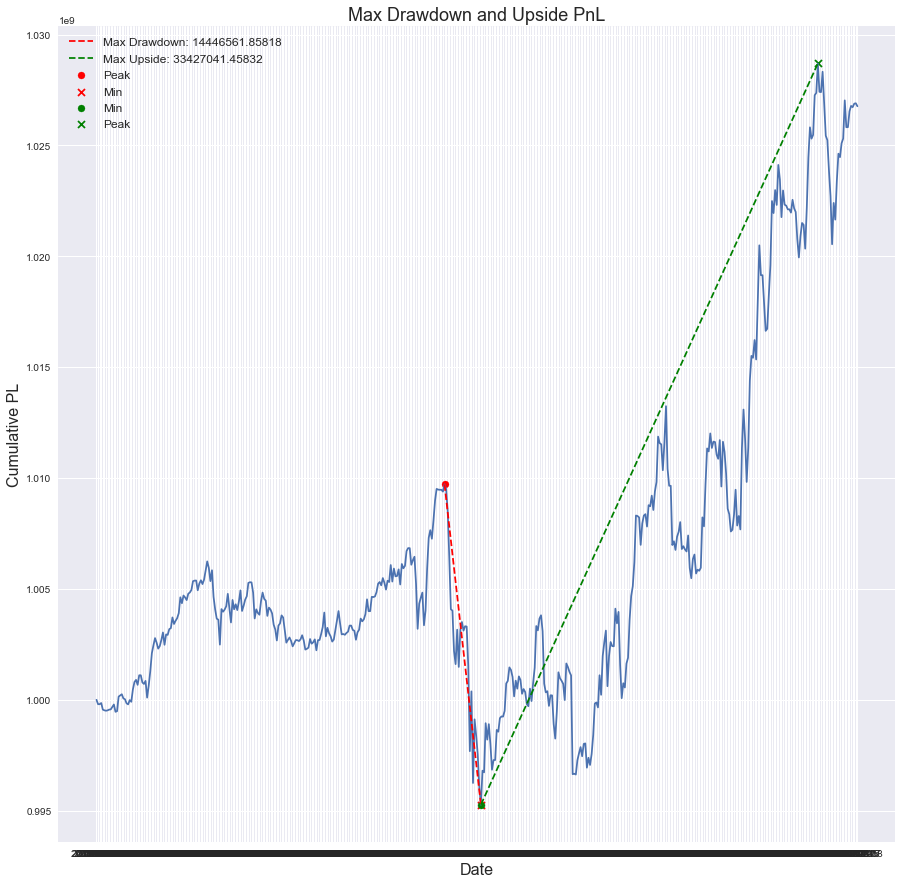

In [1]:
d.max_drawdown((15,15),'sample_path.pkl')

 The maximum drawdown of the strategy with a starting capital of $\$$1 000 000 000 is $\$$14 446 561 which represents a significant amount of money but our starting capital is so high that the relative impact of it is absorbed by it. On the other side of the coin, the maximum upside is slightly more than twice the maximum drawdown at $\$$33 427 041. Let's see the distribution of the returns of our strategy.

P-value of the D'Agostino and Pearson's test = 1.790953999731229e-11


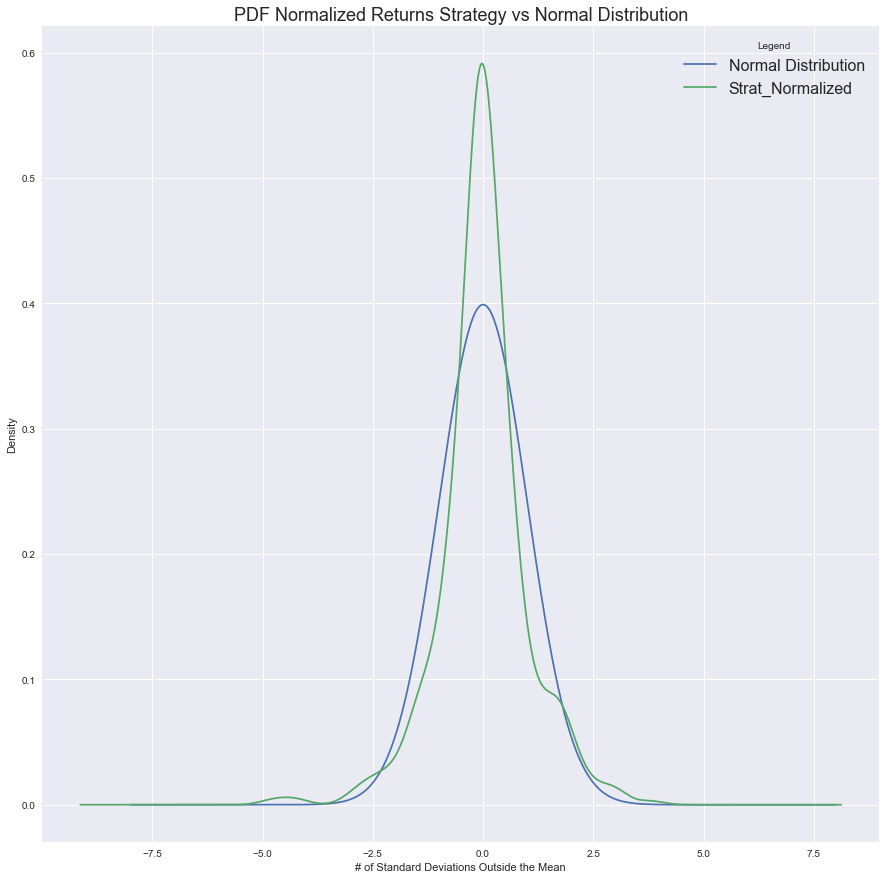

In [2]:
d.strategy_ret_versus_normal((15,15),'sample_path.pkl')

It looks like our strategy exhibit some kurtosis and if we look at the tails, we can see that tail events are much more likely than a standard normal distribution. Running a D'Agostino and Pearson's test on the normality of the returns, we see that we get an extremely low value. There is strong evidence that we can reject the null hypothesis that our returns are normaly distributed. 

In [5]:
d.returns_stats('sample_path.pkl')

,Returns Statistics
Mean,0.000055
Median,0.000024
Std Dev,0.000937
1st Quartile,-0.000317
3rd Quartile,0.000451
Skew,-0.307572
Kurtosis,3.250586


We can see that the kurtosis is fairly high and that the skewness is slightly negative. Let's now look at some Time Series analysis of the returns of the strategy.

ADF Stat: -14.8168 
 p-value: 0.0000


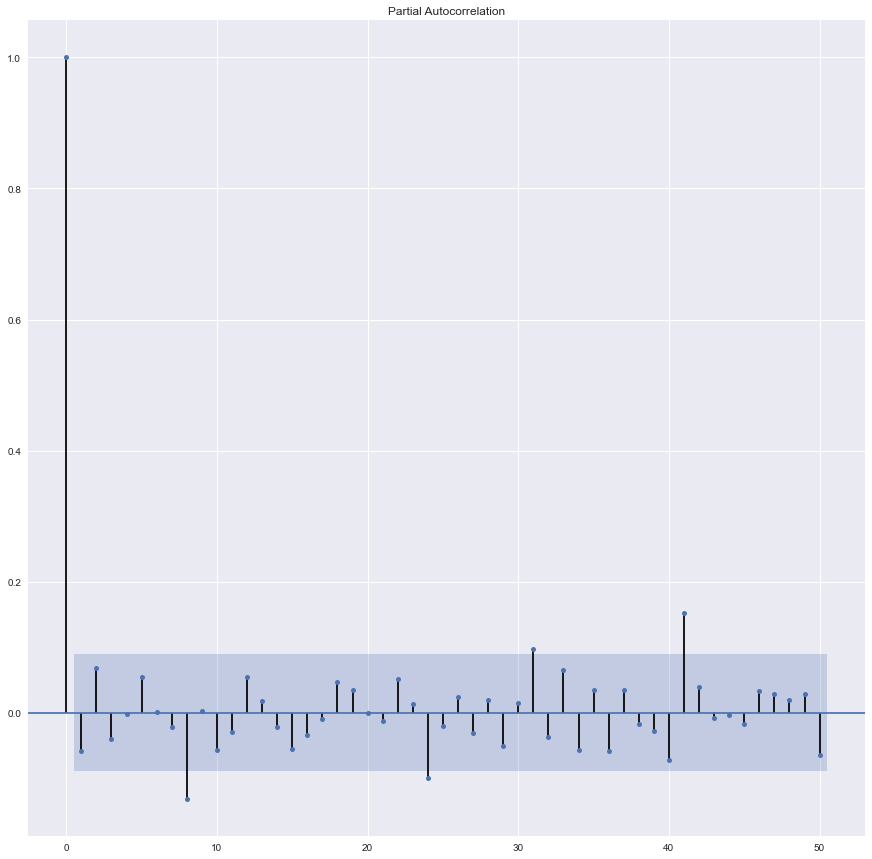

In [5]:
d.pacf_adf_stats((15,15),'sample_path.pkl')

From the Augmented Dickey-Fuller test p-value, we can reject the hypothesis that there is a unit root is present in the sample and our sample is likely stationary. We can also visually see that the there doesn't seem to be any trend along the PACF graph where only a few values are outside the confidence interval of 95%. This can easily be explained that you you're looking at 50 lags there is a good chance you'd observe ~2-4 samples outside the confidence interval and that is what we see here. Let's make sure by looking at the seasonality of our returns.

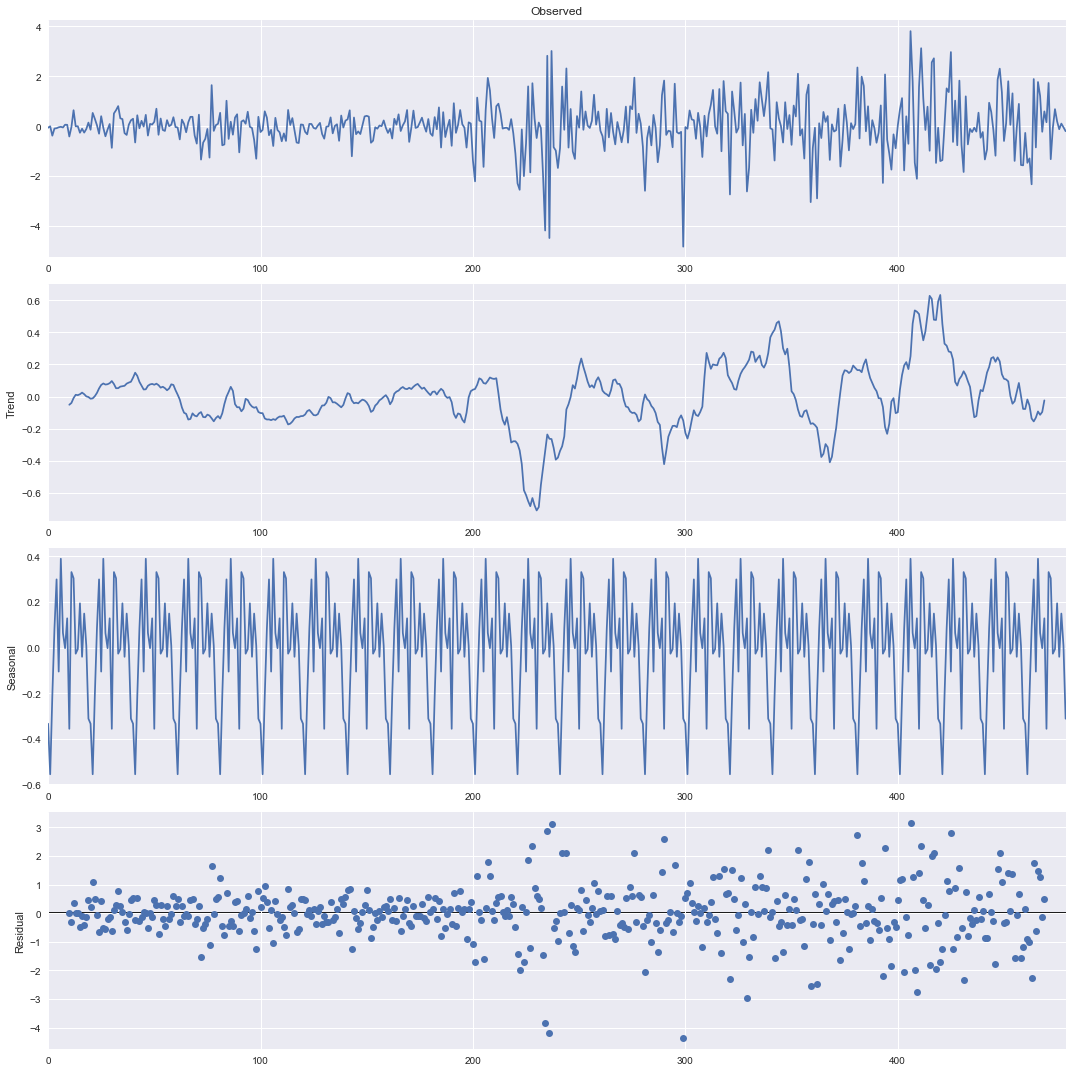

In [6]:
d.seasonality((15,15),'sample_path.pkl')

The interesting information is is related to the residuals. If we pay more attention to the residuals, at around ~200 which coincides with the COVID-19 pandemic in 2020, the residual variance starts to significantly increase. A QQ plot should be able to extract more information on the tails of the distribution of the residuals.

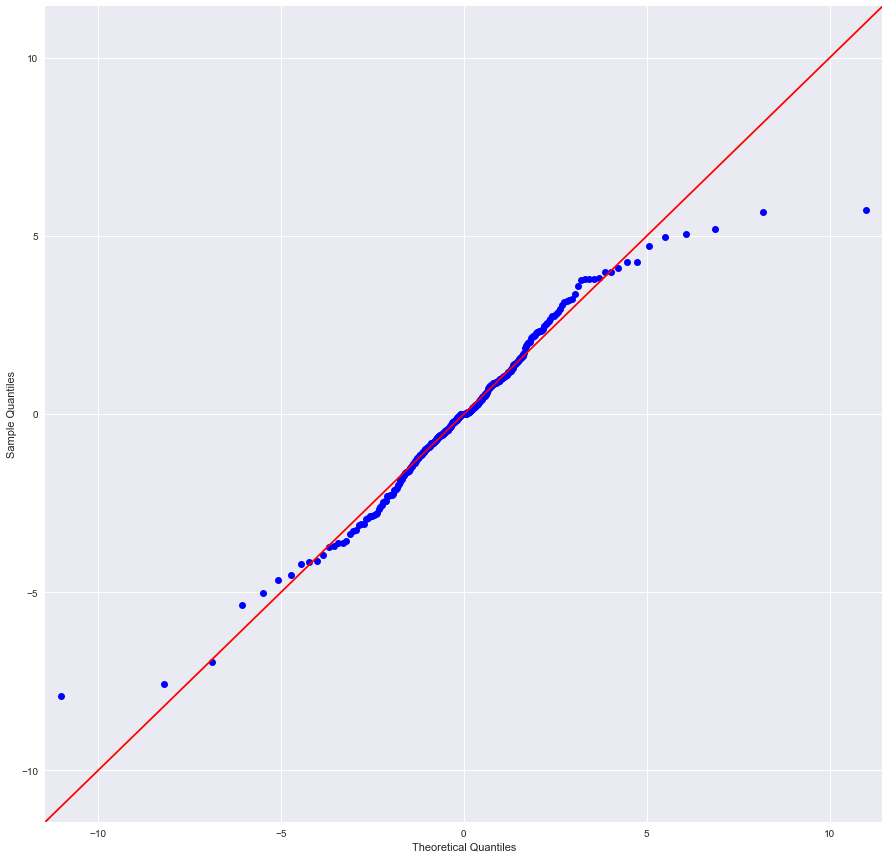

In [6]:
d.seasonality((15,15),'sample_path.pkl',qq_plot = True)

We can clearly see the result of the kurtosis in action here. The tails of the distributed start to significantly diverge from normality. Another interesting thing to look at is how correlated is our strategy to Farma-French Factors? 

,Beta
Factors,
Mkt-RF,0.590734
SMB,0.054715
HML,0.114999
RF,-0.061452
Strat_Ret,1.000000
Mkt,0.590684


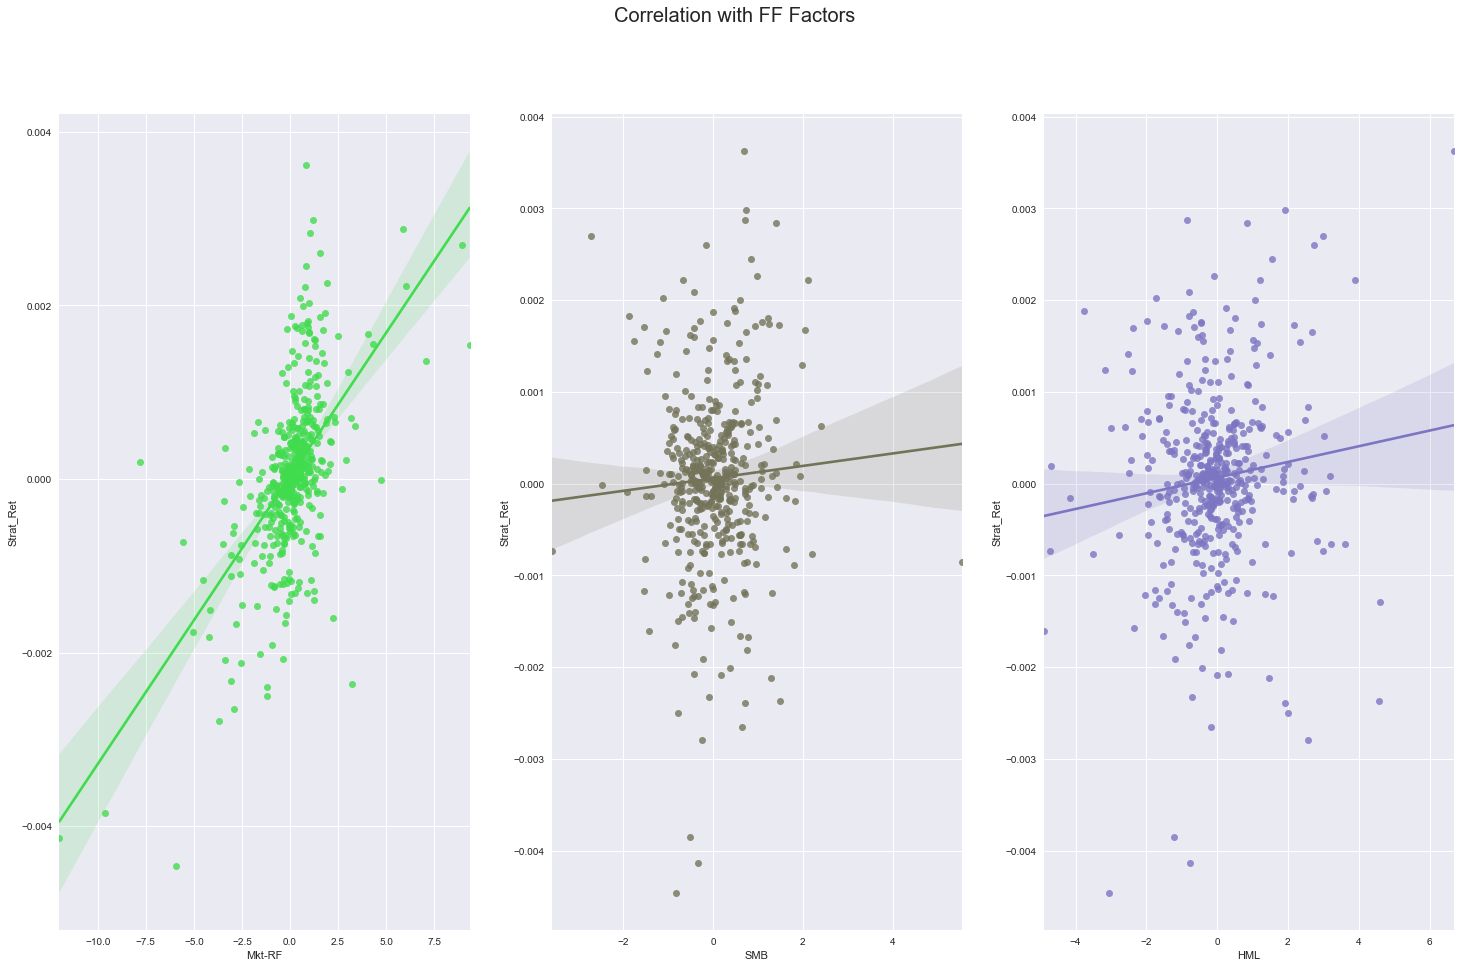

In [9]:
d.ff_correlation((25,15),'sample_path.pkl')

There is significant correlation with the Market but not with the Small Minus Big and High Minus Low factors. We can also look how our strategy correlates with the market in downturns.

In [10]:
d.downside_beta('sample_path.pkl')

,Downside Beta Regression
const,-0.000098
Mkt-RF,0.031876
R${^2}$,0.340151


The strategy seems to be highly uncorrelated to the market in downturns which is a good thing when market goes down. Given that the overall strategy is somewhat highly correlated to the market but not in downturns, it seems like we are able to capitalize when the market goes down but also not be correlated to when it falls. Let's look at some performance metrics now.

In [11]:
d.performance_metric('sample_path.pkl')

,Score
Metrics,
Sharpe_Ratio,0.158106
Sortino_Ratio,0.505873
Treynor_Ratio,0.001842


In [9]:
d.get_net_long(.001,2.5)

ValueError: could not convert string to float: '[0.37776468]'

### Trading Strategy Parameter optimization

Let's take a look at the effect of varying some parameters.

#### Short Bias
Here is the performance of the strategy with the same parameters except leverage and short bias. Leverage is set to .02 and the stop loss threshold is set at 50pbs (i.e. 75% of the position value). The short bias is varied.

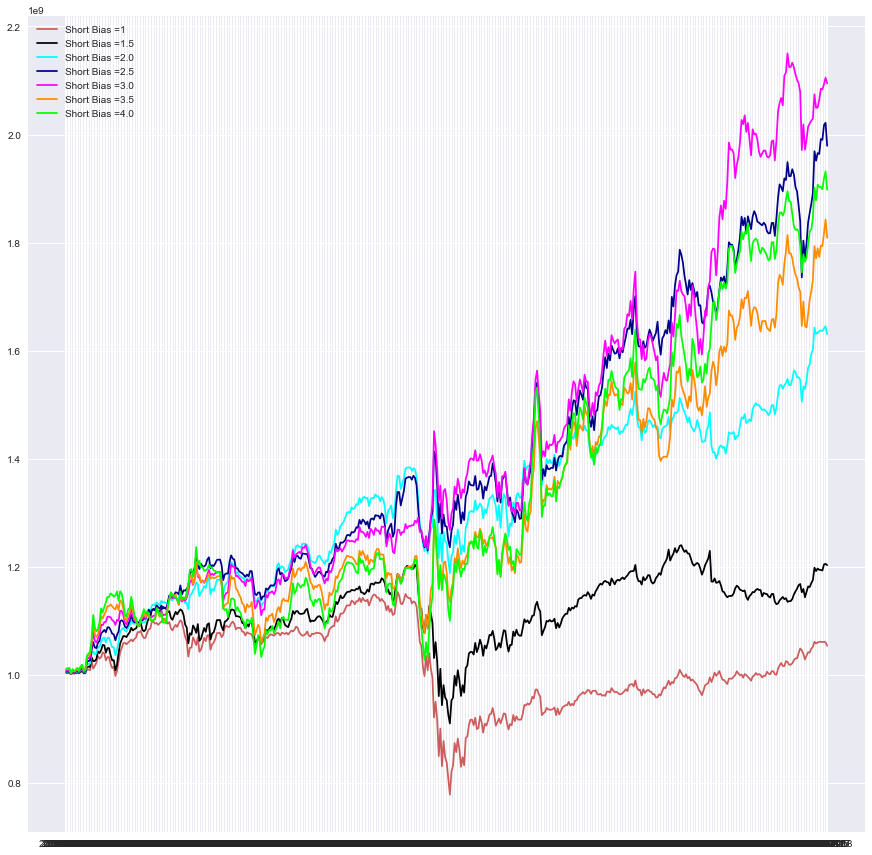

In [5]:
d.plot_short_bias((15,15), 'short_bias.pkl')

If start scaling the trade size up and down  by PnL, you can see that increasing the short bias has a dramamtic effect on returns. There are a few possible reasons for this:
* Since March 2020 had a big drawdown year, the increasing the short bias evened out the PnL for that period by avoiding losses. If you scale position size by leverage, this should increase your time-average (compounded) return by clipping the left tail
* Not too many senators were short after the lows in March, so there wasn't a huge drag on performance in the uptrend.  

And here is the same chart with leverage of .001, which is a more more ergodic scenario (the trade size is smaller as a percent of AUM). 

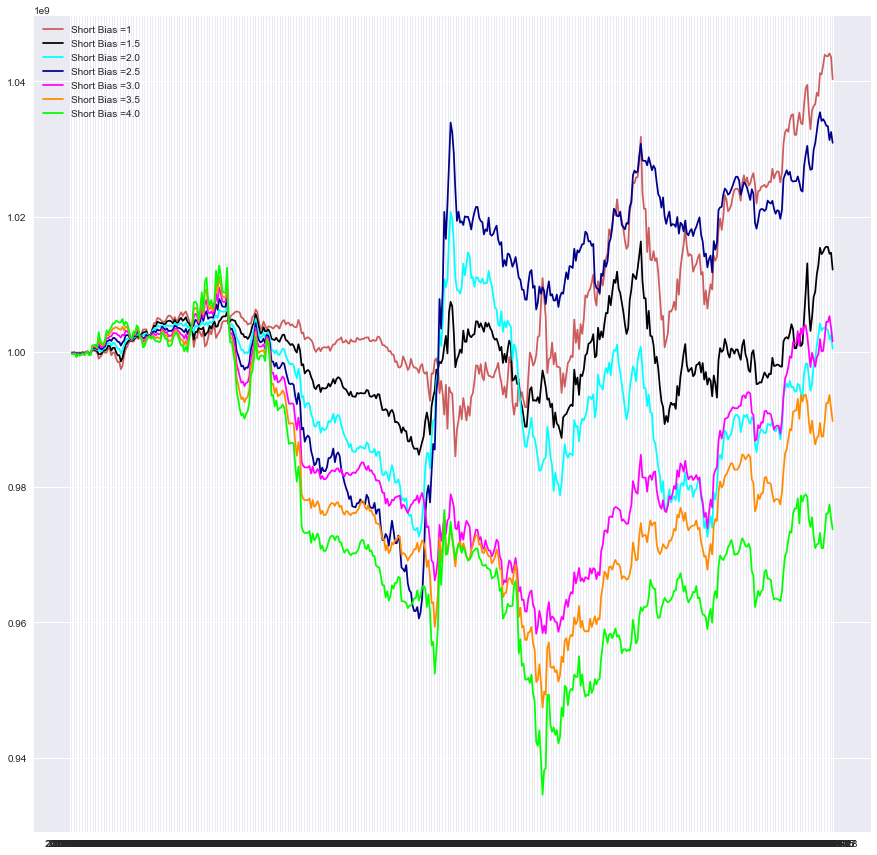

In [4]:
d.plot_short_bias((15,15), 'short_bias_ergodic.pkl',.001)

Here varying the short bias actually hurts you because you aren't as woried about compounding returns, so clipping the left tail doesn't help. In fact, the higher performing strategy has a short bias of 1, which is equally weighting the returns.


Remember that the short bias determines the multiplier in position sizing between long and short trades. In terms of setting this short bias parameter out of sample, there are a few things to consider:

  *  The short bias is to some extent counteracting the macroeconomic information contained in Senatorial trade disclosures. If you put the short bias too high, you are limiting the information that you can derive from the dataset that tells you about the overall market direction. Since Senators have specialized insider info in particular related to macroeconomic events, this can cost you (as shown in the lower leverage strategy performance).
  
  
  *  On the other hand, increasing the short bias helps decorrelate the strategy from the overall market. This is particularly useful if your allocators already have overall market exposure (a likely guess). 
  
  
  *  In other market scenarios, the short bias may have different impacts than the ones discussed here, but the general principles remain the same, except for the scenario in which the majority of the trades generated by the model are short trades. In this instance, increasing the short bias would actually exacerbate the left tail and decrease long term growth. In this situation you would probably need to make some kind of manual adjustment to the parameter. 
  
  
  * Since in real life you would probably be scaling the position sizes as you trade to adjust for your AUM, it makes sense to have a short bias setting of around 2.5

#### Leverage

Here are various in sample PnL paths which assume a short bias of 2.5, a stop loss threshold of half the trade size, a funding cost of 300bps, and a market impact of 50bps. The longest the strategy can hold a position is 100 days. 

In [3]:
import Ana as d
d.plot_leverage_effects((20,20),'leverage_effects_with_50%stop.pkl')

<Figure size 2000x2000 with 1 Axes>

It looks like a leverage of about .01 or .02 or is optimal for the other parameter settings that we chose. Leverage of 3% or higher is clearly overtrading. For different parameters the optimal leverage will probably be different. In particular, if the short bias were higher, optimal leverage would probably also be higher. If we were to actually implement this, we'd probably be looking at somewhere around .01 leverage to err on the side of caution given unexpected market conditions in the future. In addition, the sample does include some extreme volatilty, so we might be able to get away with being more agressive in pushing the leverage than one would otherwise be allowed to. 

#### Stop Loss  Ratio
The way the stop losses are implemented, is that if you are down on the position beyond a certain percentage of the strategies total AUM, you are liquidated. Let's take a look at a few sample PnL which differ in their stop loss thresholds. For these plots, the chosen parameter settings are those which have more or less robust performance so far -- short bias of 2.5, leverage of .015, and assuming a 300bps funding cost as well as 50bps market impact. 

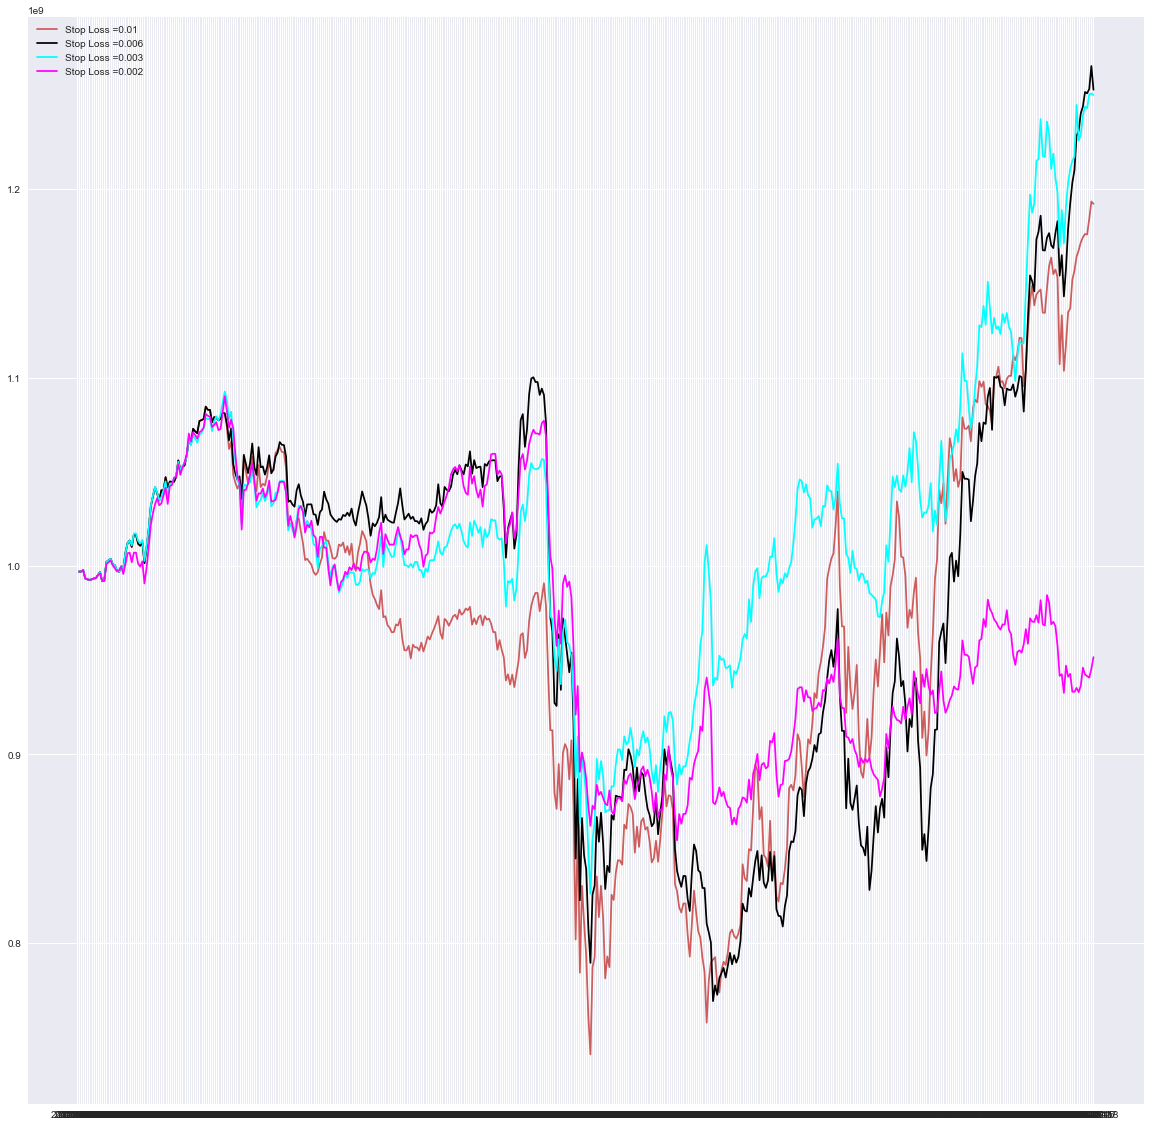

In [2]:
import Ana as d
d.plot_stoploss((20,20), 'stoploss.pkl')

#### Market Impact
How scalable is the strategy? Here I plot some sample PnL's with leverage of .02 and short bias of 2. The other parameters are less informative because the metric that matters is trade frequency, which is high for all parameter settings. 

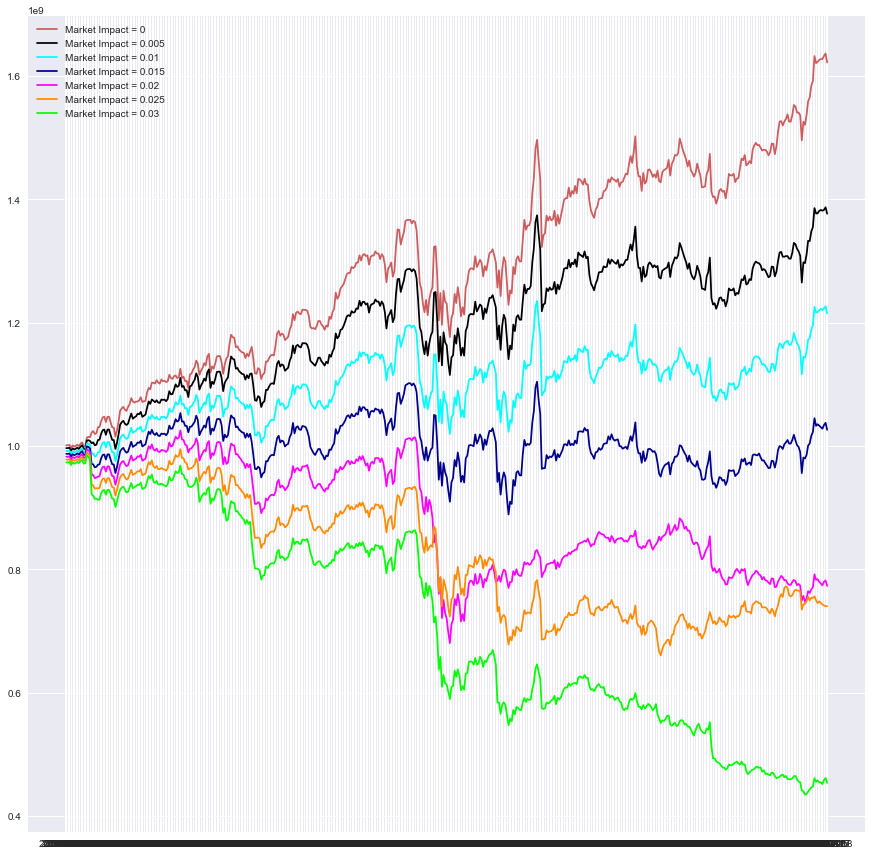

In [6]:
d.check_robustness_to_market_impact((15,15),'market_impact_df.pkl')

You see there are large PnL differences for even small changes in how the backtest simulates the market impact. The strategy is not robust to increases in trading costs. This suggests that the 1bn capital allocation is perhaps a little optimistic --  at that size maybe you would have to use some kind of prime broker VWAP algorithm to get like 20-30bps discount excecution, but even so the trading costs are significant limitation to strategy capacity. Especially since some of the stocks are smaller cap and less liquid.

#### Statistics

### Reference
Chafen Zhu, Li Wang, Tengfei Yang,
“Swimming Ducks Forecast the Coming of Spring”—The predictability of aggregate insider trading on future market returns in the Chinese market,
China Journal of Accounting Research,
Volume 7, Issue 3,
2014,
Pages 179-201,
ISSN 1755-3091,
https://doi.org/10.1016/j.cjar.2014.08.001.

Safer, A., &amp; Wilamowski, B. M. (1998). Neural networks and Mars for prediction using legal insider stock trading data (dissertation), http://www.eng.auburn.edu/~wilambm/pap/1998/ANNIE98_LegalInsider_Safer_Sprecher.pdf

In [7]:
import pandas as pd
test_data = pd.read_pickle('test_data.pkl')
test_data_sectoral = pd.read_pickle('test_data_sectoral.pkl')

In [8]:
test_data

,file_date,tx_date,full_name,order_type,ticker,lower_bound,higher_bound,ret_90,spy_90,Beta,adjusted_ret,win/loss,size
0,2019-04-17,2019-03-11,Shelley M Capito,0,MCO,1001,15000,0.093426,0.040489,0.444293,0.017989,1,8000.5
1,2019-04-17,2019-03-15,Sheldon Whitehouse,0,BA,15001,50000,-0.033548,0.040489,0.314315,0.012726,0,32500.5
2,2019-04-17,2019-03-11,Shelley M Capito,0,PM,1001,15000,-0.031528,0.040489,0.192807,0.007806,1,8000.5
3,2019-04-17,2019-03-11,Shelley M Capito,0,SRE,1001,15000,0.101727,0.040489,0.147615,0.005977,1,8000.5
4,2019-04-17,2019-03-11,Shelley M Capito,0,TSM,1001,15000,-0.028691,0.040489,0.336203,0.013612,0,8000.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,2021-02-08,2021-01-27,"Jerry Moran,",0,COST,1001,15000,0.062409,0.073753,0.641964,0.047347,1,8000.5
1723,2021-02-18,2021-01-20,Ron L Wyden,1,AAPL,1001,15000,-0.037078,0.054996,0.508053,0.027941,1,8000.5
1724,2021-02-18,2021-01-27,Ron L Wyden,1,AAPL,1001,15000,-0.037078,0.054996,0.508053,0.027941,1,8000.5
1725,2021-02-18,2021-01-27,Ron L Wyden,1,DIS,1001,15000,-0.075027,0.054996,0.475335,0.026141,1,8000.5
